# Generative Probabilistic Approach with LDA for Document Categorization

In [1]:
import re 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma,gammaln
from scipy.stats import dirichlet

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

%matplotlib inline

stop_words = stopwords.words('english')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/sxia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sxia1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Extract $\bm{\alpha}$ and $\bm{\beta}$ from data
## clean up data and tokenize text


### Web of science paper data

46985
['CS ' 'Medical ' 'Civil ' 'ECE ' 'biochemistry ' 'MAE ' 'Psychology  ']


/tmp/ipykernel_24523/4099232812.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))


Text(0.5, 1.0, 'abstract word count')

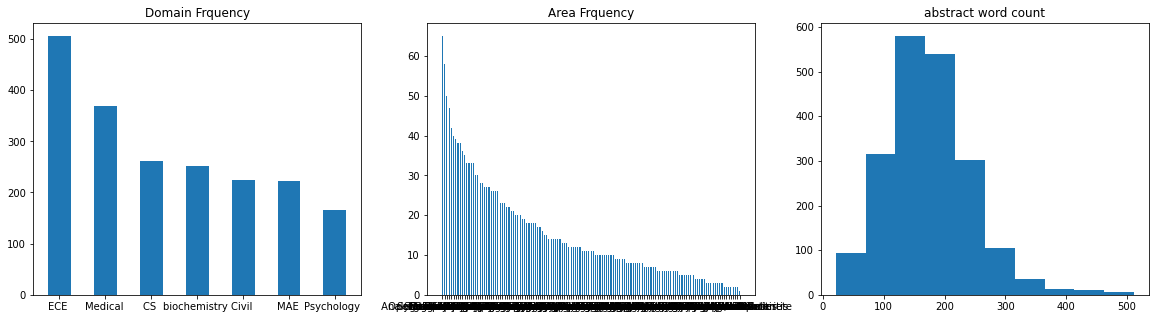

In [2]:
# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(2000) #use first 2000
print(df_paper.Domain.unique())

# remove puncutations and number, then tokenize each text
text_tokenized = list(map(lambda abstract_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',abstract_i.lower())), df_paper['Abstract']))
len(text_tokenized)
df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))

fig,axs = plt.subplots(1,3,figsize=(20,5))
categories = df_paper.Domain.value_counts().index
counts = df_paper.Domain.value_counts().values
axs[0].bar(categories, counts, width=0.5)
axs[0].set_title("Domain Frquency")

categories = df_paper.area.value_counts().index
counts = df_paper.area.value_counts().values
axs[1].bar(categories, counts, width=0.5)
axs[1].set_title("Area Frquency")

axs[2].hist(df_paper.n_words)
axs[2].set_title("abstract word count")

## remove stopwords, make biargam, lemmatize

/tmp/ipykernel_24523/1049156276.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))


Text(0.5, 1.0, 'abstract without stop words word count')

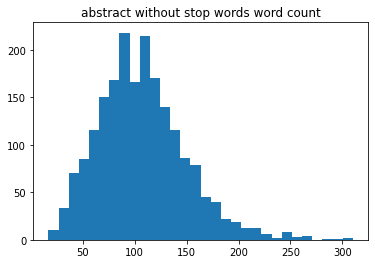

In [3]:
#helper function for lemmatization
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n' #if not belong to any, default is noun, inclunding N

def lemmatize_with_pos(abstract_toekenized):
    abstract_tagged = nltk.pos_tag(abstract_toekenized)
    tags = list(map(lambda token: get_wordnet_pos(token[1]),abstract_tagged))
    abstract_lemmatized = list(map(lemmatizer.lemmatize,abstract_toekenized,tags))
    return abstract_lemmatized


# Creating Bigram: find words frequently occur together
bigram = gensim.models.Phrases(text_tokenized, min_count=5, threshold=100)  
#come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
bigram_freeze = bigram.freeze()
#import nltk lemmatizer
lemmatizer = WordNetLemmatizer()

def prepare_token(text_tokenized_list):
    # remove stopwords and puntuation, 
    text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized_list))

    #apply biagram model
    word_and_bigram_list = list(map(lambda abstract_cleaned: bigram[abstract_cleaned],text_stopwords_removed))

    # lemmatize
    abstract_lemmatized = list(map(lemmatize_with_pos,word_and_bigram_list))
    return abstract_lemmatized

abstract_lemmatized = prepare_token(text_tokenized)
df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))
plt.hist(df_paper.n_words_removed,bins=30)
plt.title("abstract without stop words word count")

['use', 'model', 'system', 'study', 'result', 'method', 'propose', 'show', 'control', 'base', 'present', 'design', 'analysis', 'high', 'data', 'also', 'patient', 'cell', 'effect', 'increase', 'two', 'different', 'time', 'develop', 'provide', 'new', 'process', 'include', 'rights_reserved', 'approach', 'compare', 'performance', 'test', 'algorithm', 'paper', 'low', 'c_elsevier', 'level', 'power', 'measure', 'structure', 'well', 'find', 'parameter', 'one', 'application', 'may', 'function', 'current', 'energy', 'obtain', 'condition', 'simulation', 'group', 'dynamic']


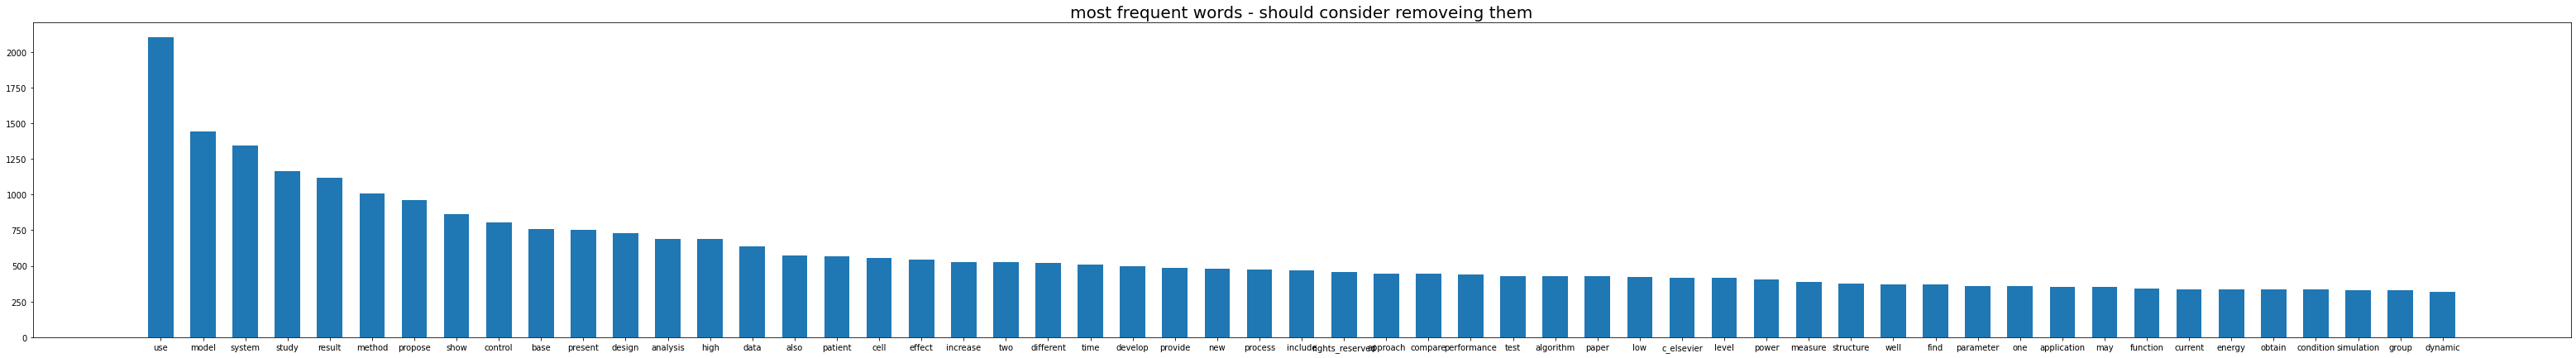

In [4]:
def check_frequent_words(corpus,top_n):
    all_corpus_together=np.concatenate(corpus)
    (word, counts) = np.unique(all_corpus_together, return_counts=True)
    frequencies = np.asarray((word, counts)).T
    count_df = pd.DataFrame(data=frequencies,columns = ['word','freq'])
    count_df.freq = count_df.freq.astype(int)
    count_df.sort_values(by=['freq'],axis=0,ascending=False,ignore_index=True,inplace=True)
    print(list(count_df.head(top_n).word))
    plt.figure(figsize=(top_n,7))
    plt.bar(count_df[:top_n].word,height=count_df[:top_n].freq,width=0.6,align='center')
    plt.title("most frequent words - should consider removeing them",fontsize=20)
    plt.show()
    return count_df

count_df =check_frequent_words(abstract_lemmatized,55)

['obtain', 'condition', 'simulation', 'group', 'dynamic', 'change', 'frequency', 'improve', 'treatment', 'reduce', 'demonstrate', 'circuit', 'work', 'however', 'expression', 'gene', 'response', 'signal', 'human', 'sample']


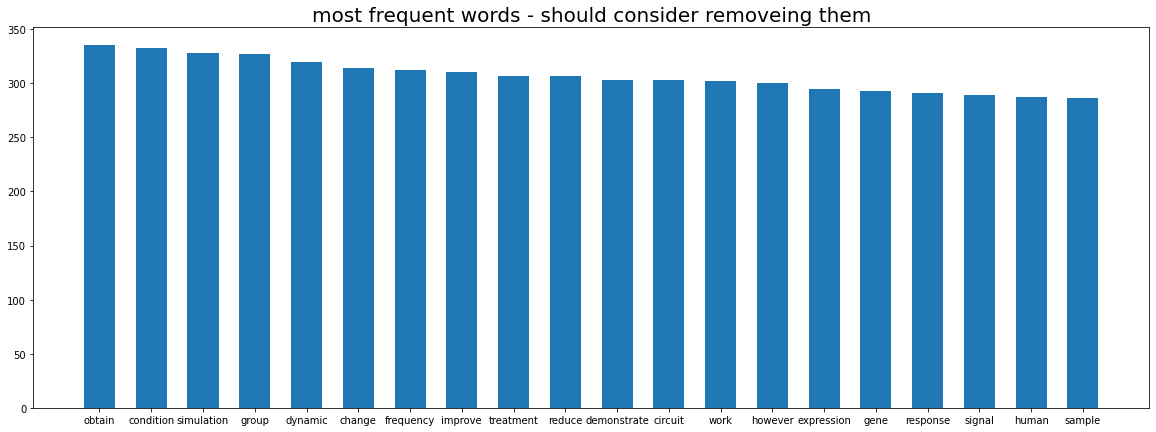

/tmp/ipykernel_24523/1339668137.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))


Text(200, 150, 'median length: 87')

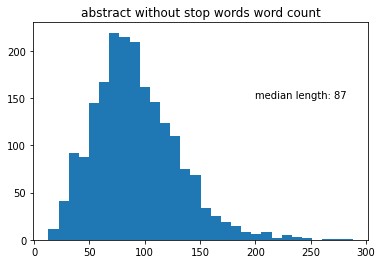

In [5]:
# remove top 50 most frequent words
top_n = list(count_df[:50].word)
abstract_lemmatized_cleaned = list(map(lambda abstract: list(filter(lambda word: word not in top_n, abstract)),abstract_lemmatized))
check_frequent_words(abstract_lemmatized_cleaned,top_n=20)

df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))
median_count = np.median(df_paper.n_words_lemmatize_clean)
plt.hist(df_paper.n_words_lemmatize_clean,bins=30)
plt.title("abstract without stop words word count")
plt.text(200,150,"median length: %d"%median_count,fontsize=10)


In [6]:
np.median(df_paper.n_words_lemmatize_clean)

87.0

## make dictionary and corpus for the inputs to Gensim LDA Model

In [7]:
# define mapping between words to integer ids
word2id = Dictionary(abstract_lemmatized_cleaned)
dictionary = word2id.token2id
vocab_size = len(dictionary)
print("total vocabulary size", vocab_size)
# word2id.token2id gives the dictonary between words and their ids

# define corpus from documents
# documents: a list of lists of strings
# corpus: bag of words: each text = [(word_id, frequency), (word_id, frequency)]
corpus = list(map(word2id.doc2bow,abstract_lemmatized))
print([(word2id[id], freq) for id, freq in corpus[1][:10]])

total vocabulary size 22477
[('p', 1), ('suggest', 1), ('accumulates', 1), ('accumulation', 2), ('across', 1), ('age', 2), ('aggregate', 1), ('among', 1), ('ap', 1), ('appear', 1)]


## Use LDA to extract topic distribution and topic-term distribution

In [8]:
# Train the model on the corpus. #420
lda_model = LdaModel(corpus, 
                num_topics=len(df_paper.Domain.unique()),
                id2word = word2id,
                random_state=420,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)

# alpha = parameter for Dirichlet Distribution . higer alpha more towards the center, i.e. a mixture of different topic for one document
alpha = lda_model.alpha
print(alpha)
# alpha all parameters are equal => have no prior information to favor one component over any other

#beta = #distribution over word weights in each topic
topic_term_distribution = lda_model.get_topics()
print(np.shape(topic_term_distribution))

print(lda_model.print_topics(num_words=20)) 
#okay, i think i need remove "model", "use", "method", "system", "purpose", "result", "study", "show"



[0.07246257 0.92490155 0.28433117 0.884133   0.43683913 0.16651341
 0.2041837 ]
(7, 22477)
[(0, '0.013*"soil" + 0.011*"jak" + 0.009*"iron" + 0.009*"crop" + 0.009*"followup" + 0.008*"soft" + 0.008*"risk_factors" + 0.007*"successful" + 0.007*"fibrosis" + 0.007*"gi" + 0.007*"median" + 0.006*"wf" + 0.006*"initiate" + 0.006*"surgical" + 0.005*"cable" + 0.005*"pmf" + 0.004*"acs" + 0.004*"betacatenin" + 0.004*"geotextile" + 0.004*"thrombosis"'), (1, '0.005*"signal" + 0.005*"range" + 0.005*"reduce" + 0.005*"frequency" + 0.004*"stress" + 0.004*"measurement" + 0.004*"rate" + 0.004*"circuit" + 0.004*"obtain" + 0.004*"experimental" + 0.004*"controller" + 0.004*"surface" + 0.004*"load" + 0.004*"response" + 0.004*"sample" + 0.003*"characteristic" + 0.003*"material" + 0.003*"demonstrate" + 0.003*"active" + 0.003*"property"'), (2, '0.011*"joint" + 0.009*"engine" + 0.007*"protocol" + 0.007*"emerge" + 0.007*"procedure" + 0.005*"capture" + 0.005*"secure" + 0.005*"motor" + 0.005*"hybrid" + 0.005*"module" 

In [9]:
#num2topic ={0:"Civil", 1:"Medical",2:"MAE",3:"ECE",4:"biochemistry",5:"CS", 6:"Psychology"}
num2topic ={0:"Medical", 1:"ECE",2:"Civil",3:"CS",4:"Psychology",5:"MAE", 6:"biochemistry"}

from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("ldaWOS.model")
lda_model.save(temp_file)
# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

In [10]:
vis_ldamodel = pyLDAvis.gensim_models.prepare(lda_model,corpus,word2id)
vis_ldamodel

/home/sxia1/.nlp_env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/mis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.177077 -0.154681       1        1  28.966027
3      0.224110 -0.110128       2        1  27.364568
4      0.164683  0.172727       3        1  18.233934
6     -0.028274  0.262679       4        1  12.600310
2     -0.197333 -0.081371       5        1   5.984800
5     -0.166389 -0.069240       6        1   5.229821
0     -0.173874 -0.019986       7        1   1.620541, topic_info=                    Term        Freq       Total Category  logprob  loglift
297           expression  375.000000  375.000000  Default  30.0000  30.0000
300                 gene  279.000000  279.000000  Default  29.0000  29.0000
2412                flow  173.000000  173.000000  Default  28.0000  28.0000
1646         temperature  218.000000  218.000000  Default  27.0000  27.0000
3794          adolescent  265.000000  265.000000  Default  26.0000  26.0000
...                  ...         ...         ...      ...      ...      ...
5064               smoke    9.414538   10.199634   Topic7  -5.7558   4.0423
19904          contactor    9.207830   10.000241   Topic7  -5.7781   4.0399
21518                smf    9.160968    9.959651   Topic7  -5.7832   4.0388
9483                crop   27.422307   35.524420   Topic7  -4.6867   3.8635
4435   suspension_bridge    9.779265   19.689050   Topic7  -5.7178   3.4226

[354 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5374      5  0.968594  abstract
509       1  0.084706    accord
509       2  0.742422    accord
509       3  0.169412    accord
641       2  0.984801   account
...     ...       ...       ...
3670      3  0.989189     woman
1278      1  0.236219      work
1278      2  0.761149      work
677       2  0.190590      year
677       3  0.804053      year

[503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 7, 3, 6, 1])

## evalute model perplexity and coherence 
how to interpret these scores?
coherence score is not high

In [68]:
# A lower perplexity score indicates better generalization performance.
perplexity = lda_model.log_perplexity(corpus)
print('Perplexity: ', perplexity )

# get coherence value u_mass
# probability = the number of documents in which the word occurs divided by the total number of documents"
cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary = word2id,coherence='u_mass')
coherence_umass = cm.get_coherence() 
print('UMass Coherence Score: ', coherence_umass)

# Compute Coherence Score using c_v
# CV measure is based on the Pointwise Mutual Information score
coherence_model_lda = CoherenceModel(model=lda_model, texts=abstract_lemmatized_cleaned, dictionary=word2id, coherence="c_v")
coherence_cv = coherence_model_lda.get_coherence()
print('C_v Coherence Score: ', coherence_cv)

Perplexity:  -9.04655412127769
UMass Coherence Score:  -7.4124212883426495
C_v Coherence Score:  0.4682717360041694


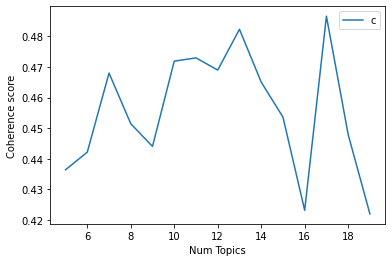

In [69]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=3):
    """
    Compute c_v coherence for various number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus,num_topics=num_topics,
                id2word = dictionary,
                random_state=121,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=word2id, corpus=corpus, texts=abstract_lemmatized_cleaned, start=5, limit=20, step=1)
n = range(5, 20, 1)
plt.plot(n, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
model8 = model_list[3]
print(model8.print_topics(num_words=13)) 

[(0, '0.023*"adolescent" + 0.014*"social" + 0.013*"parent" + 0.012*"health" + 0.011*"group" + 0.010*"people" + 0.009*"intervention" + 0.009*"student" + 0.009*"care" + 0.009*"age" + 0.008*"disorder" + 0.008*"participant" + 0.007*"mental_health"'), (1, '0.024*"gene" + 0.015*"controller" + 0.011*"symptom" + 0.011*"acute" + 0.010*"expression" + 0.010*"express" + 0.009*"sequence" + 0.008*"secondary" + 0.008*"plant" + 0.007*"rna" + 0.006*"platform" + 0.006*"protein" + 0.006*"processing"'), (2, '0.009*"network" + 0.008*"simulation" + 0.008*"dynamic" + 0.006*"obtain" + 0.005*"solution" + 0.005*"experimental" + 0.005*"flow" + 0.005*"efficiency" + 0.005*"load" + 0.005*"frequency" + 0.005*"program" + 0.004*"equation" + 0.004*"framework"'), (3, '0.011*"hdpp" + 0.011*"pregnancy" + 0.010*"regression" + 0.010*"involvement" + 0.009*"nmolminmg" + 0.009*"et" + 0.008*"putative" + 0.008*"improved" + 0.007*"pulse" + 0.007*"judgment" + 0.006*"downstream" + 0.006*"dea" + 0.006*"command"'), (4, '0.023*"inhibi

# Using the LDA model, find the topic of any given document
#### lda built in model

In [11]:
# test on 2000-2500 rows from the real data
# step1:  given an abstract/text, tokenize, find biargram, remove popular words, turn it into a bag of words
def prepare_text(text_list,BOW=True):
    tokenized = list(map(lambda text_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',text_i.lower())),text_list))
    text_uncategorized = prepare_token(tokenized)
    # map corpus to a bag of words, lda doc2idx ignore unknown words
    corpus_uncategorized  = list(map(word2id.doc2bow,text_uncategorized))
    if BOW:
        corpus_uncategorized  = list(map(lambda document: np.array(word2id.doc2bow(document)),text_uncategorized))
    else:
        corpus_uncategorized  = list(map(lambda document: np.array(word2id.doc2idx(document)),text_uncategorized))
        corpus_uncategorized = list(map(lambda document: document[document>=0],corpus_uncategorized))
    return corpus_uncategorized

#step2: infer topic distribution
def get_weight_each_topic(i,t_predict):
    find = t_predict[list(map(lambda topic: i in topic, t_predict))]
    if len(find)==0:
        return 0.0
    else:
        return find[0][1]

def get_topic_dist(model,text):
    t_predict = np.array(model[text][0])
    topic_dist_d = list(map(lambda i:get_weight_each_topic(i,t_predict),range(7)))
    return topic_dist_d

### test3
df_test = df_paper_raw[2000:2500]
topic2num = {"Medical": 0, "ECE":1, "MAE":2, "CS":3, "Psychology":4, "Civil":5,"biochemistry":6}
#topic2num = {"MAE":0,"biochemistry":1,"Civil":2,"ECE":3,"Medical":4,"CS":5,"Psychology":6}
df_test.Domain = df_test.Domain.str.replace(r'\s','')
df_test['Domain_No'] = df_test.Domain.map(topic2num)
corpus_uncategorized = prepare_text(df_test.Abstract,BOW=True)
# corpus_uncategorized[1]
topic_weight_matrix = list(map(lambda text_i:get_topic_dist(lda_model,text_i),corpus_uncategorized))
dominant_topic = np.argmax(topic_weight_matrix,axis=1)
predict_compare = pd.DataFrame({"Domain":df_test.Domain,"actual":df_test.Domain_No,"predicted":dominant_topic})
predict_compare["correct"] = np.equal(predict_compare.actual,predict_compare.predicted)
accuracy = np.sum(predict_compare['correct'])/len(predict_compare)
print("accuracy:", accuracy)
# compute accuracy by domain
accuracy_by_domain = predict_compare.groupby('Domain').apply(lambda grp: np.sum(grp.correct)/len(grp))
print("accuracy by domain", accuracy_by_domain)
predict_compare.head()


/tmp/ipykernel_24523/1624293086.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test.Domain = df_test.Domain.str.replace(r'\s','')
/home/sxia1/.nlp_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/tmp/ipykernel_24523/1624293086.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Domain_No'] = df_test.Domain.map(topic2num)


accuracy: 0.35
accuracy by domain Domain
CS              0.772727
Civil           0.055556
ECE             0.368421
MAE             0.000000
Medical         0.000000
Psychology      0.906977
biochemistry    0.635294
dtype: float64


,Domain,actual,predicted,correct
2000,biochemistry,6,6,True
2001,Civil,5,1,False
2002,MAE,2,1,False
2003,Civil,5,5,True
2004,MAE,2,1,False


In [12]:

#training 

df_train = df_paper_raw[:2000]
topic2num = {"Medical": 0, "ECE":1, "MAE":2, "CS":3, "Psychology":4, "Civil":5,"biochemistry":6}
#topic2num = {"MAE":0,"biochemistry":1,"Civil":2,"ECE":3,"Medical":4,"CS":5,"Psychology":6}
df_train.Domain = df_train.Domain.str.replace(r'\s','')
df_train['Domain_No'] = df_train.Domain.map(topic2num)

# corpus_uncategorized[1]
topic_weight_matrix_train = list(map(lambda text_i:get_topic_dist(lda_model,text_i),corpus))
dominant_topic_train = np.argmax(topic_weight_matrix_train,axis=1)
predict_compare_train = pd.DataFrame({"Domain":df_train.Domain,"actual":df_train.Domain_No,"predicted":dominant_topic_train})
predict_compare_train["correct"] = np.equal(predict_compare_train.actual,predict_compare_train.predicted)
accuracy_train = np.sum(predict_compare_train['correct'])/len(predict_compare_train)
print("accuracy:", accuracy_train)
# compute accuracy by domain
accuracy_by_domain_train = predict_compare_train.groupby('Domain').apply(lambda grp: np.sum(grp.correct)/len(grp))
print(predict_compare_train.head())
print("accuracy by domain")
accuracy_by_domain_train

/tmp/ipykernel_24523/2974559897.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train.Domain = df_train.Domain.str.replace(r'\s','')
/home/sxia1/.nlp_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/tmp/ipykernel_24523/2974559897.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Domain_No'] = df_train.Domain.map(topic2num)


accuracy: 0.438
    Domain  actual  predicted  correct
0       CS       3          1    False
1  Medical       0          4    False
2    Civil       5          3    False
3      ECE       1          2    False
4  Medical       0          1    False
accuracy by domain


Domain
CS              0.777778
Civil           0.066964
ECE             0.671937
MAE             0.022523
Medical         0.008108
Psychology      0.801205
biochemistry    0.705179
dtype: float64

# generate synthetic data using $\alpha$ and $\bm{\beta}$ to 

In [87]:
num2topic = {0:"Medical", 1:"ECE",2:"MAE",3:"CS",4:"Psychology",5:"Civil", 6:"biochemistry"}

# Possion distribution: draw sample length, lambda = median from the data
# alpha: topic mixture of each synethic text
# beta: topic-term distribution
def lda_gen(vocabulary,beta,alpha,possion_lambda):
    xi = np.random.poisson(possion_lambda) #length = sample from poisson dist
    v = np.shape(beta)[0]
    topic_proportion = np.random.dirichlet(alpha) # generate topic proportion based of a text dist
    dominant_domain = num2topic[np.argmax(topic_proportion)]
    topic_list = np.random.choice(range(v),xi,p=topic_proportion) #sample from topic proportion dist, 

    #pick a word for each topic in each document
    # frequency of the topics = topics mixture in each document
    word_bag = list(map(lambda topic_index: np.random.choice(vocabulary,p=beta[topic_index]),topic_list))
    return (dominant_domain,word_bag)

vocabulary = list(dictionary.keys())
alpha = lda_model.alpha
beta = lda_model.get_topics()
possion_lambda = median_count

synthetic_data_size = 2500
synthetic_data = [ lda_gen(vocabulary,beta,alpha,possion_lambda) for _ in range(synthetic_data_size)]
synthetic_df = pd.DataFrame(synthetic_data,columns=['Domain','Abstract'])
synthetic_df.Abstract = synthetic_df.Abstract.map(lambda a: " ".join(a))
synthetic_df.to_csv("mockdata.csv",index=False)
synthetic_df.head()


# Categorize the synthetic data with lda probabilistic classifier

In [91]:

# read data
mock_data = pd.read_csv("mockdata.csv", engine='python')
#topic2num = {"Medical": 0, "ECE":1, "MAE":2, "CS":3, "Psychology":4, "Civil":5,"biochemistry":6}
mock_data.head()

,Domain,Abstract
0,Psychology,fourier stability device nurse meet p arousal ...
1,Psychology,research manager intraspecific heuristic enhan...
2,CS,mobile amount ice associate construct zone asp...
3,CS,year proprietary carbon_dioxide combustion gap...
4,Psychology,antihistamine parental customized share thiame...


In [93]:
# extract alpha and beta from the mock data
num_topics = 7
documents = list(map(lambda abstract:abstract.split(" "),mock_data.Abstract[:2000]))
mockdata_word2id = Dictionary(documents)
mock_corpus = [mockdata_word2id .doc2bow(text) for text in documents]
mockdata_lda_model = LdaModel(mock_corpus, 
                num_topics=len(mock_data.Domain.unique()),
                id2word = mockdata_word2id,
                random_state=121,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)
print("alpha", mockdata_lda_model.alpha)
print("beta",mockdata_lda_model.show_topics(15))

alpha [0.43784472 0.3480546  2.514889   0.45890188 0.8136236  2.8937771
 2.1727703 ]
beta [(0, '0.017*"joint" + 0.014*"engine" + 0.010*"emerge" + 0.009*"procedure" + 0.008*"capture" + 0.008*"explicit" + 0.008*"protocol" + 0.008*"valve" + 0.007*"secure" + 0.007*"clear"'), (1, '0.008*"mitochondrial" + 0.008*"soil" + 0.008*"crop" + 0.008*"soft" + 0.006*"suspension_bridge" + 0.006*"gi" + 0.005*"wf" + 0.005*"acs" + 0.005*"bioprosthetic" + 0.005*"risk_factors"'), (2, '0.006*"problem" + 0.006*"work" + 0.006*"network" + 0.005*"information" + 0.005*"dynamic" + 0.005*"set" + 0.004*"strategy" + 0.004*"research" + 0.004*"case" + 0.004*"technology"'), (3, '0.012*"protein" + 0.012*"gene" + 0.010*"expression" + 0.007*"cancer" + 0.006*"inhibitor" + 0.005*"occlusion" + 0.005*"pathway" + 0.005*"mouse" + 0.005*"p" + 0.005*"metabolic"'), (4, '0.010*"flow" + 0.009*"water" + 0.008*"temperature" + 0.007*"heat" + 0.006*"wind" + 0.005*"expression" + 0.005*"combustion" + 0.005*"independent" + 0.005*"thermal" + 

In [106]:
# num2topicMock = {0:"Medicial",1:"CS",2:"MAE",3:"Civil",4:"biochemistry",5:"ECE",6:"Psychology"}
# topic2numMock = {"Medical":0,"CS":1,"MAE":2,"Civil":3,"biochemistry":4,"ECE":5,"Psychology":6}
num2topicMock = {0:"MAE",1:"Medical",2:"CS",3:"biochemistry",4:"Civil",5:"ECE",6:"Psychology"}
topic2numMock = {"MAE":0,"Medical":1,"CS":2,"biochemistry":3,"Civil":4,"ECE":5,"Psychology":6}

In [96]:
vis_ldamodel_mock = pyLDAvis.gensim_models.prepare(mockdata_lda_model,mock_corpus,mockdata_word2id)
vis_ldamodel_mock

/home/sxia1/.nlp_env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/mis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.243856 -0.167615       1        1  31.043976
2      0.257494 -0.037497       2        1  27.168857
6      0.096970  0.326007       3        1  22.123162
4     -0.166455 -0.046524       4        1   7.435916
0     -0.154199 -0.058446       5        1   5.369535
3     -0.145501 -0.004102       6        1   4.331477
1     -0.132166 -0.011823       7        1   2.527078, topic_info=             Term        Freq       Total Category  logprob  loglift
704         joint  156.000000  156.000000  Default  30.0000  30.0000
896        engine  132.000000  132.000000  Default  29.0000  29.0000
1286  temperature  221.000000  221.000000  Default  28.0000  28.0000
243         water  203.000000  203.000000  Default  27.0000  27.0000
412          flow  174.000000  174.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1921       allows   12.836965   13.616593   Topic7  -5.8326   3.6191
887          crop   34.863119   38.774273   Topic7  -4.8335   3.5718
4288         soil   35.349667   40.968334   Topic7  -4.8197   3.5306
2945   successful   14.935377   18.424641   Topic7  -5.6812   3.4682
897      fibrosis   14.183531   19.825238   Topic7  -5.7329   3.3432

[338 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2678      6  0.981486    ablation
664       5  0.987552  absorption
153       5  0.990532    abstract
4965      6  0.941946    academic
389       1  0.097655      accord
...     ...       ...         ...
607       1  0.995754     without
76        3  0.986013       woman
460       1  0.123196        work
460       2  0.875007        work
331       3  0.993382        year

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 5, 1, 4, 2])

In [103]:
# A lower perplexity score indicates better generalization performance.
mock_perplexity = mockdata_lda_model.log_perplexity(mock_corpus)
print('Perplexity: ', mock_perplexity )

# get coherence value u_mass
# probability = the number of documents in which the word occurs divided by the total number of documents"
mock_cm = CoherenceModel(model=mockdata_lda_model, corpus=mock_corpus, dictionary = mockdata_word2id,coherence='u_mass')
mock_coherence_umass = mock_cm.get_coherence() 
print('UMass Coherence Score: ', mock_coherence_umass)

# Compute Coherence Score using c_v
# CV measure is based on the Pointwise Mutual Information score
mock_coherence_model_lda = CoherenceModel(model=mockdata_lda_model, texts=documents, dictionary=mockdata_word2id, coherence="c_v")
mock_coherence_cv = mock_coherence_model_lda.get_coherence()
print('C_v Coherence Score: ', mock_coherence_cv)

Perplexity:  -8.990820876485346
UMass Coherence Score:  -4.134717354256426
C_v Coherence Score:  0.5186172903544527


In [107]:
def get_weight_each_topic(i,t_predict):
    find = t_predict[list(map(lambda topic: i in topic, t_predict))]
    if len(find)==0:
        return 0.0
    else:
        return find[0][1]

def get_topic_dist(model,text):
    t_predict = np.array(model[text][0])
    topic_dist_d = list(map(lambda i:get_weight_each_topic(i,t_predict),range(7)))
    return topic_dist_d

# accuracy on the training dataset
topic_weight_matrix = list(map(lambda text_i:get_topic_dist(mockdata_lda_model,text_i),mock_corpus))
dominant_topic = np.argmax(topic_weight_matrix,axis=1)
mock_data['Domain_No'] = mock_data.Domain.map(topic2numMock)
predict_compare = pd.DataFrame({"Domain": mock_data.Domain[:2000],"actual": mock_data.Domain_No[:2000],"predicted":dominant_topic})
predict_compare["correct"] = np.equal(predict_compare.actual,predict_compare.predicted)
accuracy = np.sum(predict_compare['correct'])/len(predict_compare)
print("overall accuracy:",accuracy)
# compute accuracy by domain
accuracy_by_domain = predict_compare.groupby('Domain').apply(lambda grp: np.sum(grp.correct)/len(grp))
print("accuracy by domain", accuracy_by_domain)
predict_compare.head()

overall accuracy: 0.7485
accuracy by domain Domain
CS              0.789625
Civil           0.384615
ECE             0.890671
MAE             0.421769
Medical         0.125000
Psychology      0.887029
biochemistry    0.233010
dtype: float64


,Domain,actual,predicted,correct
0,Psychology,6,6,True
1,Psychology,6,6,True
2,CS,2,2,True
3,CS,2,4,False
4,Psychology,6,6,True


In [108]:
#test on 2000-2500 in te mock data
mock_test = mock_data[2000:2500]
documents = list(map(lambda abstract:abstract.split(" "),mock_test.Abstract))
mock_corpus_test = [mockdata_word2id .doc2bow(text) for text in documents]

topic_weight_matrix_test = list(map(lambda text_i:get_topic_dist(mockdata_lda_model,text_i),mock_corpus_test))
dominant_topic_test = np.argmax(topic_weight_matrix_test,axis=1)
mock_test['Domain_No'] = mock_test.Domain.map(topic2numMock)
predict_compare_test = pd.DataFrame({"Domain":mock_test.Domain,"actual": mock_test.Domain_No,"predicted":dominant_topic_test})
predict_compare_test["correct"] = np.equal(predict_compare_test.actual,predict_compare_test.predicted)
test_accuracy = np.sum(predict_compare_test['correct'])/len(predict_compare_test)
print(test_accuracy)
# compute accuracy by domain
accuracy_by_domain = predict_compare_test.groupby('Domain').apply(lambda grp: np.sum(grp.correct)/len(grp))
print("accuracy by domain", accuracy_by_domain)
predict_compare_test.head()

0.732
accuracy by domain Domain
CS              0.783439
Civil           0.166667
ECE             0.937824
MAE             0.243902
Medical         0.000000
Psychology      0.959184
biochemistry    0.062500
dtype: float64


/tmp/ipykernel_5720/1188854384.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mock_test['Domain_No'] = mock_test.Domain.map(topic2numMock)


,Domain,actual,predicted,correct
2000,ECE,5,5,True
2001,ECE,5,5,True
2002,CS,2,2,True
2003,CS,2,2,True
2004,MAE,0,5,False
